<a href="https://colab.research.google.com/github/techn-0/Digital_Imaging/blob/main/triple_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3가지 복합 증강 (Scale + Brightness + Rotation) 프로젝트
## Albumentations + OpenCV를 활용한 다중 변환

**목표**: 원본 이미지를 1000장으로 3가지 변환 동시 증강
- 증강 방법: 확대/축소 + 밝기 조정 + 회전 변환
- 스케일: 3단계 (0.8, 1.0, 1.2)
- 밝기: 5단계 (0.7, 0.85, 1.0, 1.15, 1.3)
- 각도: 67단계 (-100° ~ +100°)
- 총 조합: 3 × 5 × 67 = 1005개

**사용 라이브러리**:
- Albumentations: 고성능 이미지 증강
- OpenCV: 기본 이미지 처리 및 알고리즘 원리

## 1. 라이브러리 설치 및 임포트

In [ ]:
# 필요한 라이브러리 설치
!pip install albumentations opencv-python-headless matplotlib numpy pillow

In [ ]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import files
from PIL import Image
import zipfile
from tqdm import tqdm

print(f"Albumentations 버전: {A.__version__}")
print(f"OpenCV 버전: {cv2.__version__}")

Albumentations 버전: 2.0.8
OpenCV 버전: 4.12.0


## 2. 디렉토리 설정 및 이미지 업로드

In [ ]:
# 디렉토리 생성
os.makedirs('original_images', exist_ok=True)
os.makedirs('triple_augmented', exist_ok=True)
os.makedirs('triple_results', exist_ok=True)

print("디렉토리 생성 완료")
print("- original_images: 원본 이미지 저장")
print("- triple_augmented: 3가지 복합 증강된 이미지 저장")
print("- triple_results: 분석 결과 저장")

디렉토리 생성 완료
- original_images: 원본 이미지 저장
- triple_augmented: 3가지 복합 증강된 이미지 저장
- triple_results: 분석 결과 저장


In [ ]:
# 이미지 업로드
print("원본 이미지를 업로드해주세요...")
uploaded = files.upload()

# 업로드된 파일을 original_images 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f'original_images/{filename}')
    print(f"✓ {filename} 저장 완료")

# 원본 이미지 목록 확인
original_images = list(Path('original_images').glob('*'))
original_images = [str(img) for img in original_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

print(f"\n총 {len(original_images)}개의 원본 이미지가 준비되었습니다.")

원본 이미지를 업로드해주세요...


Saving 1000012987.jpg to 1000012987.jpg
✓ 1000012987.jpg 저장 완료

총 1개의 원본 이미지가 준비되었습니다.


## 3. 3가지 복합 증강 파라미터 설정

### 목표: 1000장 생성
- 스케일: 3단계 (0.8, 1.0, 1.2)
- 밝기: 5단계 (0.7, 0.85, 1.0, 1.15, 1.3)
- 각도: 67단계 (-100° ~ +100°)
- 총 조합: 3 × 5 × 67 = 1005개

In [ ]:
# 3가지 복합 증강 파라미터 정의
SCALE_FACTORS = [0.8, 1.0, 1.2]  # 3단계
BRIGHTNESS_LEVELS = [0.7, 0.85, 1.0, 1.15, 1.3]  # 5단계
ROTATION_ANGLES = np.linspace(-100, 100, 67)  # 67단계

TARGET_COUNT = len(SCALE_FACTORS) * len(BRIGHTNESS_LEVELS) * len(ROTATION_ANGLES)

print(f"스케일 단계: {len(SCALE_FACTORS)}개 - {SCALE_FACTORS}")
print(f"밝기 단계: {len(BRIGHTNESS_LEVELS)}개 - {BRIGHTNESS_LEVELS}")
print(f"각도 단계: {len(ROTATION_ANGLES)}개 ({ROTATION_ANGLES[0]:.1f}° ~ {ROTATION_ANGLES[-1]:.1f}°)")
print(f"\n총 생성될 이미지: {len(SCALE_FACTORS)} × {len(BRIGHTNESS_LEVELS)} × {len(ROTATION_ANGLES)} = {TARGET_COUNT}장")

스케일 단계: 3개 - [0.8, 1.0, 1.2]
밝기 단계: 5개 - [0.7, 0.85, 1.0, 1.15, 1.3]
각도 단계: 67개 (-100.0° ~ 100.0°)

총 생성될 이미지: 3 × 5 × 67 = 1005장


## 4. 3가지 복합 증강 알고리즘

### 수학적 원리

세 가지 변환을 순차적으로 적용:

**1. 스케일 변환**
$$x' = s \times x, \quad y' = s \times y$$

**2. 밝기 조정**
$$I_{bright}(x, y) = \alpha \times I_{scaled}(x, y)$$

**3. 회전 변환**
$$\begin{bmatrix} x'' \\ y'' \end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix} \begin{bmatrix} x' \\ y' \end{bmatrix}$$

### 구현 방법
1. **Albumentations**: Compose로 3가지 변환 파이프라인 구성
2. **OpenCV**: 순차적으로 3가지 변환 적용

In [ ]:
def augment_triple_albumentations(image, scale_factor, brightness_factor, rotation_angle):
    """
    Albumentations를 사용한 3가지 복합 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        scale_factor: 스케일 배율 (0.8~1.2)
        brightness_factor: 밝기 배율 (0.7~1.3)
        rotation_angle: 회전 각도 (-100~100)

    Returns:
        augmented_image: 3가지 증강이 적용된 이미지
    """
    # Albumentations Compose: 3가지 변환을 순차적으로 적용
    transform = A.Compose([
        # 1. 스케일 변환
        A.Affine(
            scale=scale_factor,
            translate_percent=None,
            rotate=0,
            shear=0,
            interpolation=cv2.INTER_LINEAR,
            cval=0,
            mode=cv2.BORDER_CONSTANT,
            fit_output=False,
            p=1.0
        ),
        # 2. 밝기 조정
        A.RandomBrightnessContrast(
            brightness_limit=(brightness_factor - 1.0, brightness_factor - 1.0),
            contrast_limit=(0, 0),
            p=1.0
        ),
        # 3. 회전 변환
        A.Rotate(
            limit=(rotation_angle, rotation_angle),
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=1.0
        ),
    ])

    # 증강 적용
    augmented = transform(image=image)
    return augmented['image']


def augment_triple_opencv(image, scale_factor, brightness_factor, rotation_angle):
    """
    OpenCV를 사용한 3가지 복합 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        scale_factor: 스케일 배율
        brightness_factor: 밝기 배율
        rotation_angle: 회전 각도

    Returns:
        augmented_image: 3가지 증강이 적용된 이미지
    """
    height, width = image.shape[:2]

    # 1. 스케일 변환
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    scaled = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # 원본 크기로 맞추기
    if scale_factor < 1.0:
        pad_h = height - new_height
        pad_w = width - new_width
        scaled = cv2.copyMakeBorder(scaled, pad_h//2, pad_h-pad_h//2,
                                    pad_w//2, pad_w-pad_w//2,
                                    cv2.BORDER_CONSTANT, value=0)
    else:
        start_h = (new_height - height) // 2
        start_w = (new_width - width) // 2
        scaled = scaled[start_h:start_h+height, start_w:start_w+width]

    # 2. 밝기 조정
    brightened = cv2.convertScaleAbs(scaled, alpha=brightness_factor, beta=0)

    # 3. 회전 변환
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale=1.0)
    rotated = cv2.warpAffine(brightened, rotation_matrix, (width, height),
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated

print("✓ 3가지 복합 증강 함수 정의 완료")

✓ 3가지 복합 증강 함수 정의 완료


## 5. 알고리즘 비교 및 샘플 생성

/tmp/ipython-input-262403836.py:17: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-262403836.py:35: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-586912380.py:41: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-586912380.py:41: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-586912380.py:41: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-586912380.py:41: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-586912380.py:41: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-586912380.py:41: UserWarning: Glyp

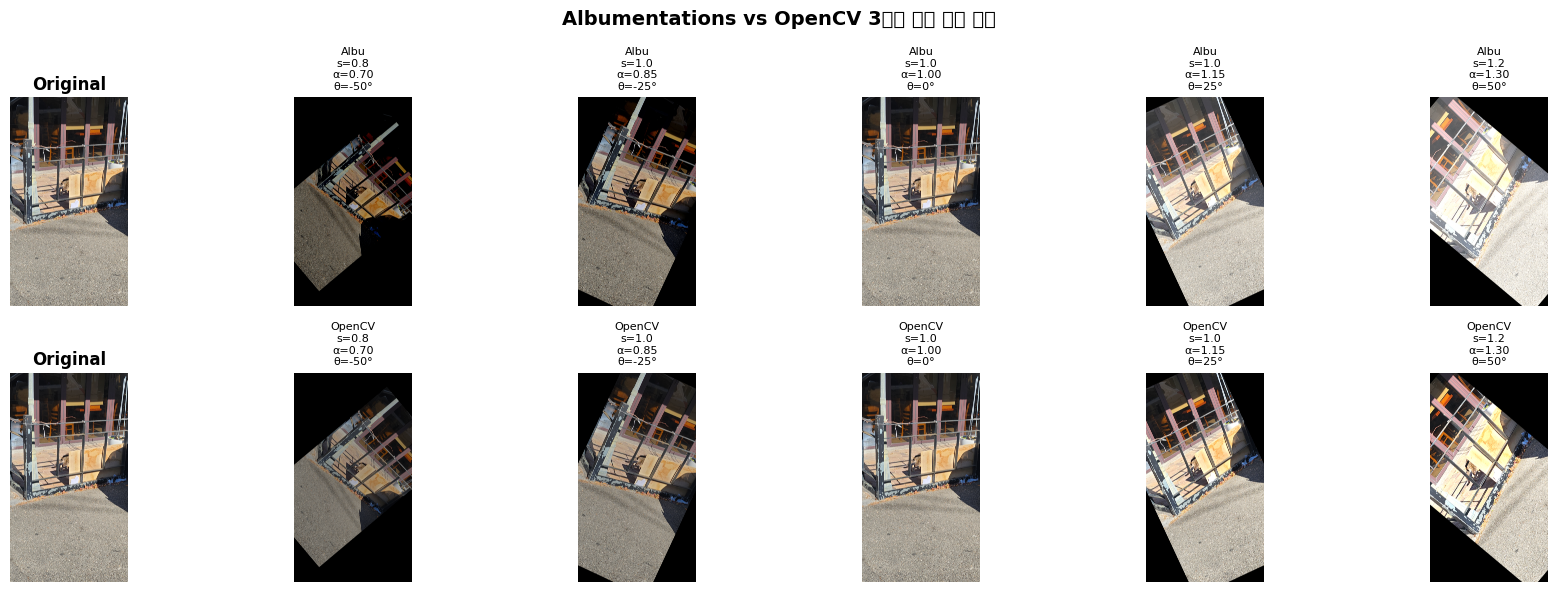

✓ 알고리즘 비교 이미지 저장: triple_results/algorithm_comparison.png


In [ ]:
# 첫 번째 원본 이미지로 샘플 생성
if len(original_images) > 0:
    sample_image_path = original_images[0]
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 테스트 파라미터 (스케일 × 밝기 × 각도)
    test_params = [
        (0.8, 0.7, -50),
        (1.0, 0.85, -25),
        (1.0, 1.0, 0),
        (1.0, 1.15, 25),
        (1.2, 1.3, 50)
    ]

    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # 첫 번째 행: Albumentations
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    for idx, (scale, brightness, angle) in enumerate(test_params, 1):
        aug_img = augment_triple_albumentations(sample_image, scale, brightness, angle)
        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'Albu\ns={scale:.1f}\nα={brightness:.2f}\nθ={angle}°', fontsize=8)
        axes[0, idx].axis('off')

    # 두 번째 행: OpenCV
    axes[1, 0].imshow(sample_image)
    axes[1, 0].set_title('Original', fontweight='bold')
    axes[1, 0].axis('off')

    for idx, (scale, brightness, angle) in enumerate(test_params, 1):
        aug_img = augment_triple_opencv(sample_image, scale, brightness, angle)
        axes[1, idx].imshow(aug_img)
        axes[1, idx].set_title(f'OpenCV\ns={scale:.1f}\nα={brightness:.2f}\nθ={angle}°', fontsize=8)
        axes[1, idx].axis('off')

    plt.suptitle('Albumentations vs OpenCV 3가지 복합 증강 비교', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('triple_results/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 알고리즘 비교 이미지 저장: triple_results/algorithm_comparison.png")
else:
    print("⚠ 원본 이미지를 먼저 업로드해주세요.")

## 6. 3D 파라미터 공간 샘플링

/tmp/ipython-input-262403836.py:17: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-262403836.py:35: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-1821797040.py:20: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1821797040.py:20: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1821797040.py:20: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1821797040.py:20: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1821797040.py:20: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1821797040.py:20: UserWarning: 

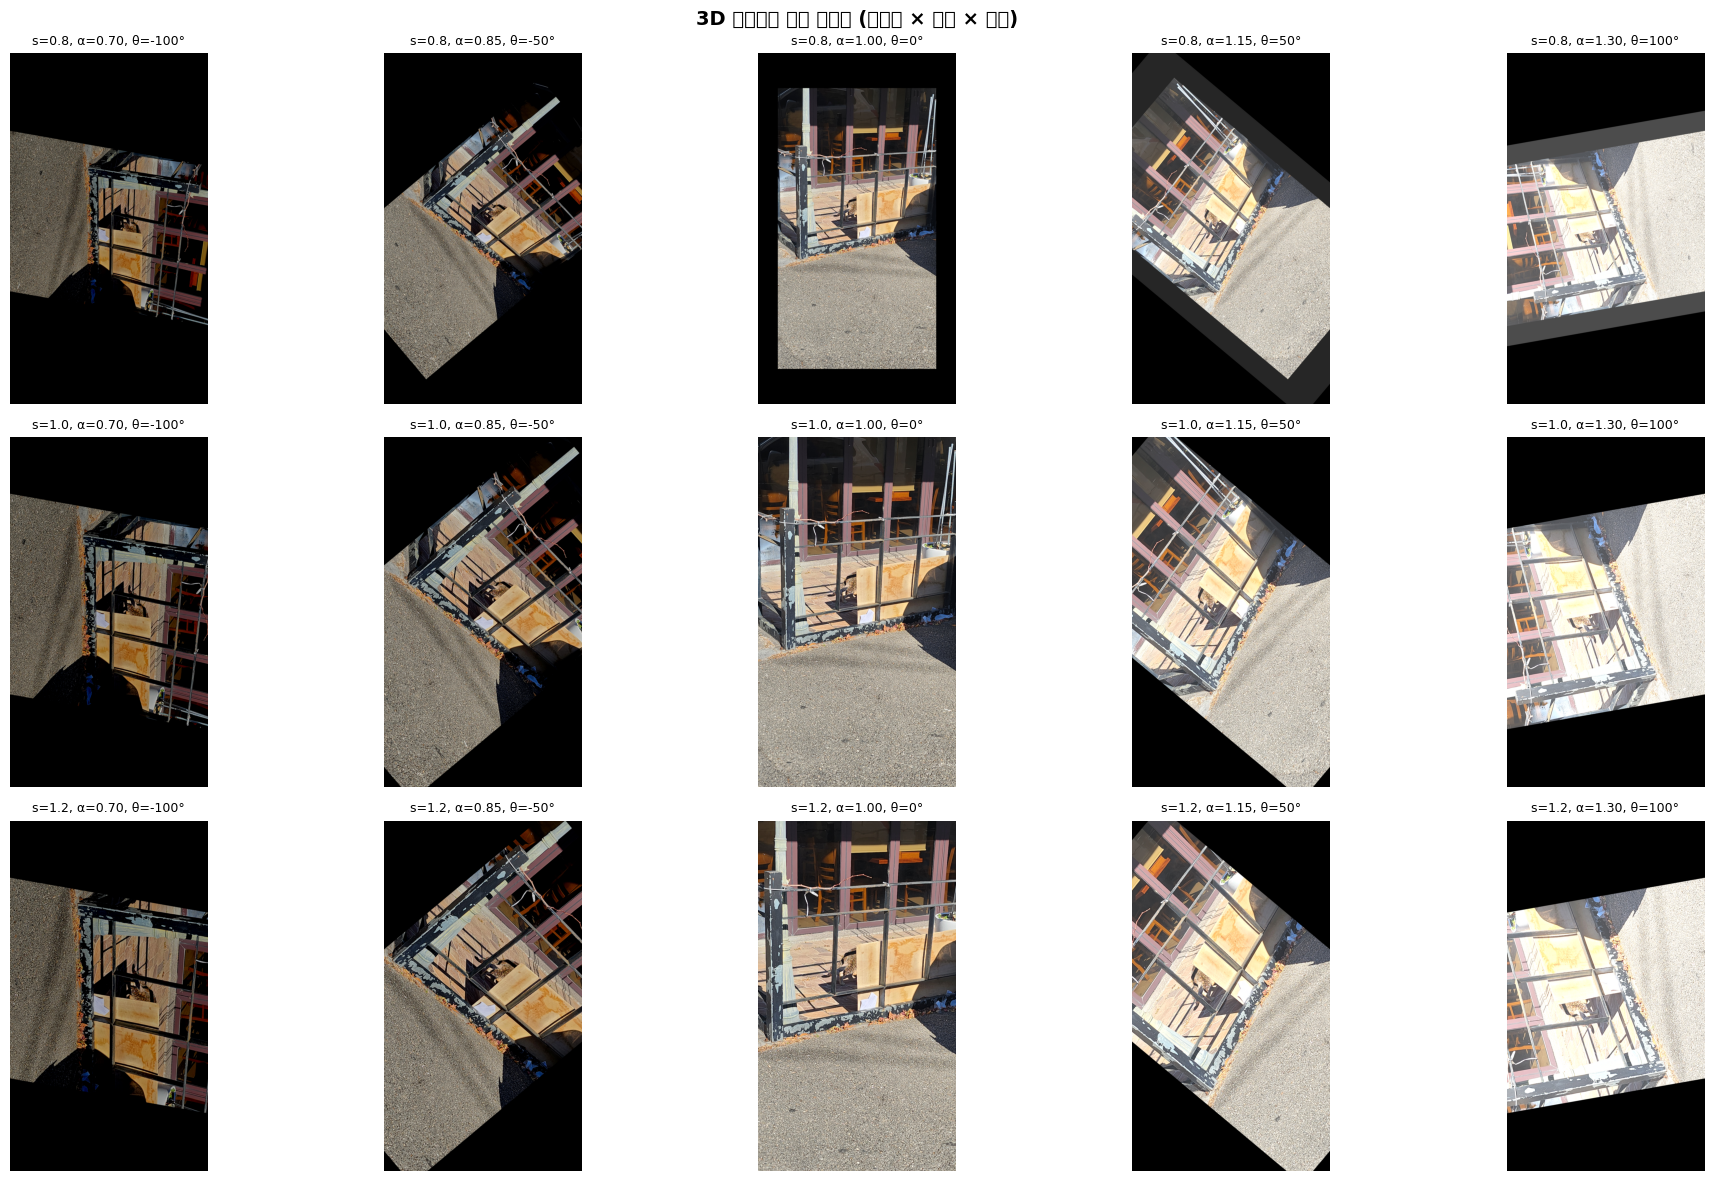

✓ 3D 파라미터 샘플링 저장: triple_results/3d_parameter_sampling.png


In [ ]:
# 3차원 파라미터 공간의 대표 샘플 시각화
if len(original_images) > 0:
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()

    # 각 차원에서 대표값 선택
    sample_combinations = [
        (0.8, 0.7, -100), (0.8, 0.85, -50), (0.8, 1.0, 0), (0.8, 1.15, 50), (0.8, 1.3, 100),
        (1.0, 0.7, -100), (1.0, 0.85, -50), (1.0, 1.0, 0), (1.0, 1.15, 50), (1.0, 1.3, 100),
        (1.2, 0.7, -100), (1.2, 0.85, -50), (1.2, 1.0, 0), (1.2, 1.15, 50), (1.2, 1.3, 100)
    ]

    for idx, (scale, brightness, angle) in enumerate(sample_combinations):
        aug_img = augment_triple_albumentations(sample_image, scale, brightness, angle)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f's={scale:.1f}, α={brightness:.2f}, θ={angle:.0f}°', fontsize=9)
        axes[idx].axis('off')

    plt.suptitle('3D 파라미터 공간 샘플링 (스케일 × 밝기 × 각도)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('triple_results/3d_parameter_sampling.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 3D 파라미터 샘플링 저장: triple_results/3d_parameter_sampling.png")

## 7. 전체 이미지 3가지 복합 증강 수행 (1005장 생성)

In [ ]:
def perform_triple_augmentation(image_paths, output_dir, method='albumentations'):
    """
    전체 이미지 3가지 복합 증강 수행

    Args:
        image_paths: 원본 이미지 경로 리스트
        output_dir: 출력 디렉토리
        method: 'albumentations' 또는 'opencv'
    """
    augment_func = augment_triple_albumentations if method == 'albumentations' else augment_triple_opencv

    total_augmentations = 0
    images_per_original = len(SCALE_FACTORS) * len(BRIGHTNESS_LEVELS) * len(ROTATION_ANGLES)

    print(f"\n{'='*70}")
    print(f"3가지 복합 증강 시작: {method.upper()} 방식")
    print(f"원본 이미지: {len(image_paths)}개")
    print(f"이미지당 생성 개수: {images_per_original}개")
    print(f"예상 총 생성 개수: {len(image_paths) * images_per_original}개")
    print(f"{'='*70}\n")

    for img_idx, img_path in enumerate(image_paths):
        # 이미지 로드
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_name = Path(img_path).stem

        print(f"[{img_idx+1}/{len(image_paths)}] 처리 중: {img_name}")

        # 모든 스케일, 밝기, 각도의 조합에 대해 증강
        with tqdm(total=images_per_original, desc=f"  3가지 복합 증강 진행") as pbar:
            for scale_idx, scale in enumerate(SCALE_FACTORS):
                for bright_idx, brightness in enumerate(BRIGHTNESS_LEVELS):
                    for angle_idx, angle in enumerate(ROTATION_ANGLES):
                        # 증강 수행
                        augmented = augment_func(image, scale, brightness, angle)

                        # 파일명 생성
                        output_filename = f"{img_name}_s{scale_idx}_b{bright_idx}_a{angle_idx:03d}.jpg"
                        output_path = os.path.join(output_dir, output_filename)

                        # 저장 (RGB -> BGR 변환)
                        cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

                        total_augmentations += 1
                        pbar.update(1)

        print(f"  ✓ {img_name}: {images_per_original}개 생성 완료\n")

    print(f"\n{'='*70}")
    print(f"3가지 복합 증강 완료!")
    print(f"총 생성된 이미지: {total_augmentations}개")
    print(f"저장 위치: {output_dir}")
    print(f"{'='*70}\n")

    return total_augmentations

In [ ]:
# Albumentations로 3가지 복합 증강 수행
total_count = perform_triple_augmentation(
    original_images,
    'triple_augmented',
    method='albumentations'
)


3가지 복합 증강 시작: ALBUMENTATIONS 방식
원본 이미지: 1개
이미지당 생성 개수: 1005개
예상 총 생성 개수: 1005개

[1/1] 처리 중: 1000012987


  3가지 복합 증강 진행:   0%|          | 0/1005 [00:00<?, ?it/s]/tmp/ipython-input-262403836.py:17: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-262403836.py:35: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
  3가지 복합 증강 진행: 100%|██████████| 1005/1005 [03:35<00:00,  4.66it/s]

  ✓ 1000012987: 1005개 생성 완료


3가지 복합 증강 완료!
총 생성된 이미지: 1005개
저장 위치: triple_augmented



## 8. 증강 결과 분석 및 통계

/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

총 증강된 이미지 개수: 1005개
목표 달성: ✓ 성공


/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:51: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2155586215.py:52: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.savefig('triple_results/distribution_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-2155586215.py:52: UserWarning: Glyph 48120 (\N{HANGUL SYLL

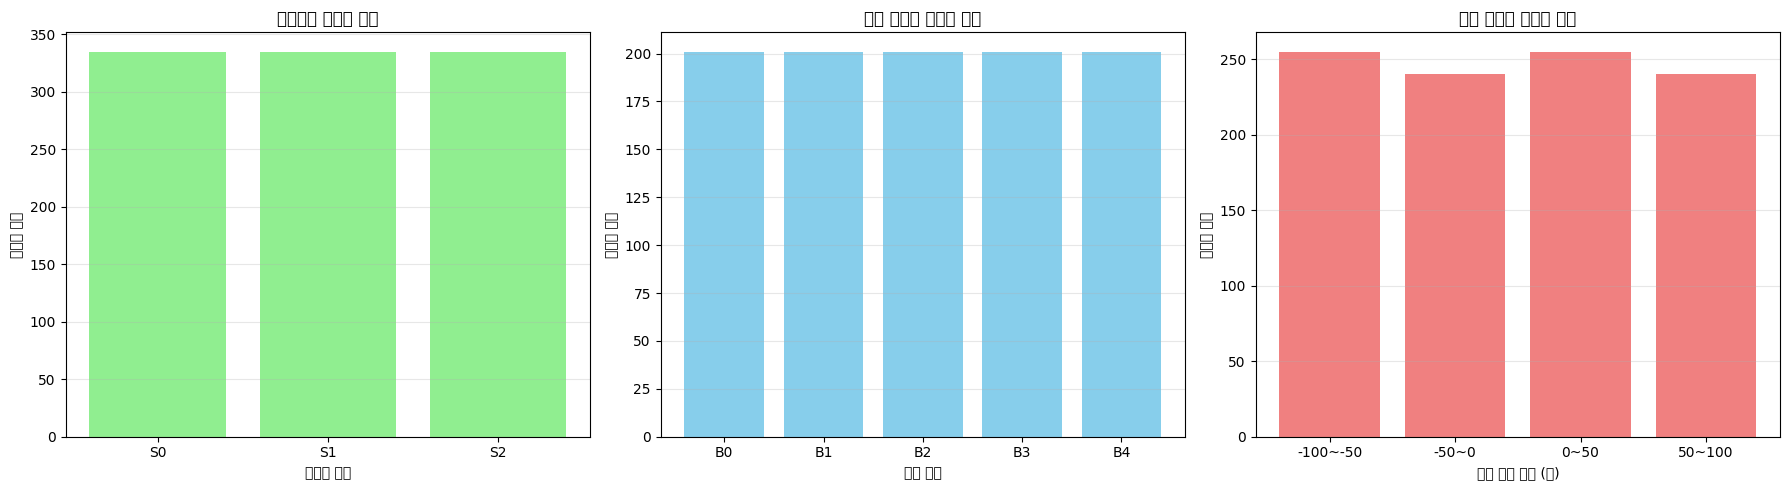

✓ 분포 분석 저장: triple_results/distribution_analysis.png


In [ ]:
# 생성된 이미지 개수 확인
augmented_files = list(Path('triple_augmented').glob('*.jpg'))
print(f"총 증강된 이미지 개수: {len(augmented_files)}개")
print(f"목표 달성: {'✓ 성공' if len(augmented_files) >= 1000 else '✗ 미달성'}")

# 각 파라미터별 분포
scale_counts = {f"S{i}": 0 for i in range(len(SCALE_FACTORS))}
brightness_counts = {f"B{i}": 0 for i in range(len(BRIGHTNESS_LEVELS))}
angle_bins = [-100, -50, 0, 50, 100]
angle_counts = {f"{angle_bins[i]}~{angle_bins[i+1]}": 0 for i in range(len(angle_bins)-1)}

for file in augmented_files:
    parts = file.stem.split('_')
    for part in parts:
        if part.startswith('s') and len(part) == 2:
            scale_counts[f"S{part[1]}"] += 1
        if part.startswith('b') and len(part) == 2:
            brightness_counts[f"B{part[1]}"] += 1
        if part.startswith('a'):
            a_idx = int(part[1:])
            angle = ROTATION_ANGLES[a_idx]
            for i in range(len(angle_bins)-1):
                if angle_bins[i] <= angle < angle_bins[i+1]:
                    angle_counts[f"{angle_bins[i]}~{angle_bins[i+1]}"] += 1
                    break

# 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 스케일 분포
ax1.bar(scale_counts.keys(), scale_counts.values(), color='lightgreen')
ax1.set_title('스케일별 이미지 분포', fontsize=12, fontweight='bold')
ax1.set_xlabel('스케일 레벨')
ax1.set_ylabel('이미지 개수')
ax1.grid(axis='y', alpha=0.3)

# 밝기 분포
ax2.bar(brightness_counts.keys(), brightness_counts.values(), color='skyblue')
ax2.set_title('밝기 레벨별 이미지 분포', fontsize=12, fontweight='bold')
ax2.set_xlabel('밝기 레벨')
ax2.set_ylabel('이미지 개수')
ax2.grid(axis='y', alpha=0.3)

# 각도 분포
ax3.bar(angle_counts.keys(), angle_counts.values(), color='lightcoral')
ax3.set_title('회전 각도별 이미지 분포', fontsize=12, fontweight='bold')
ax3.set_xlabel('회전 각도 범위 (도)')
ax3.set_ylabel('이미지 개수')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('triple_results/distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 분포 분석 저장: triple_results/distribution_analysis.png")

## 9. 랜덤 샘플 시각화

/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2274780584.py:17: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout

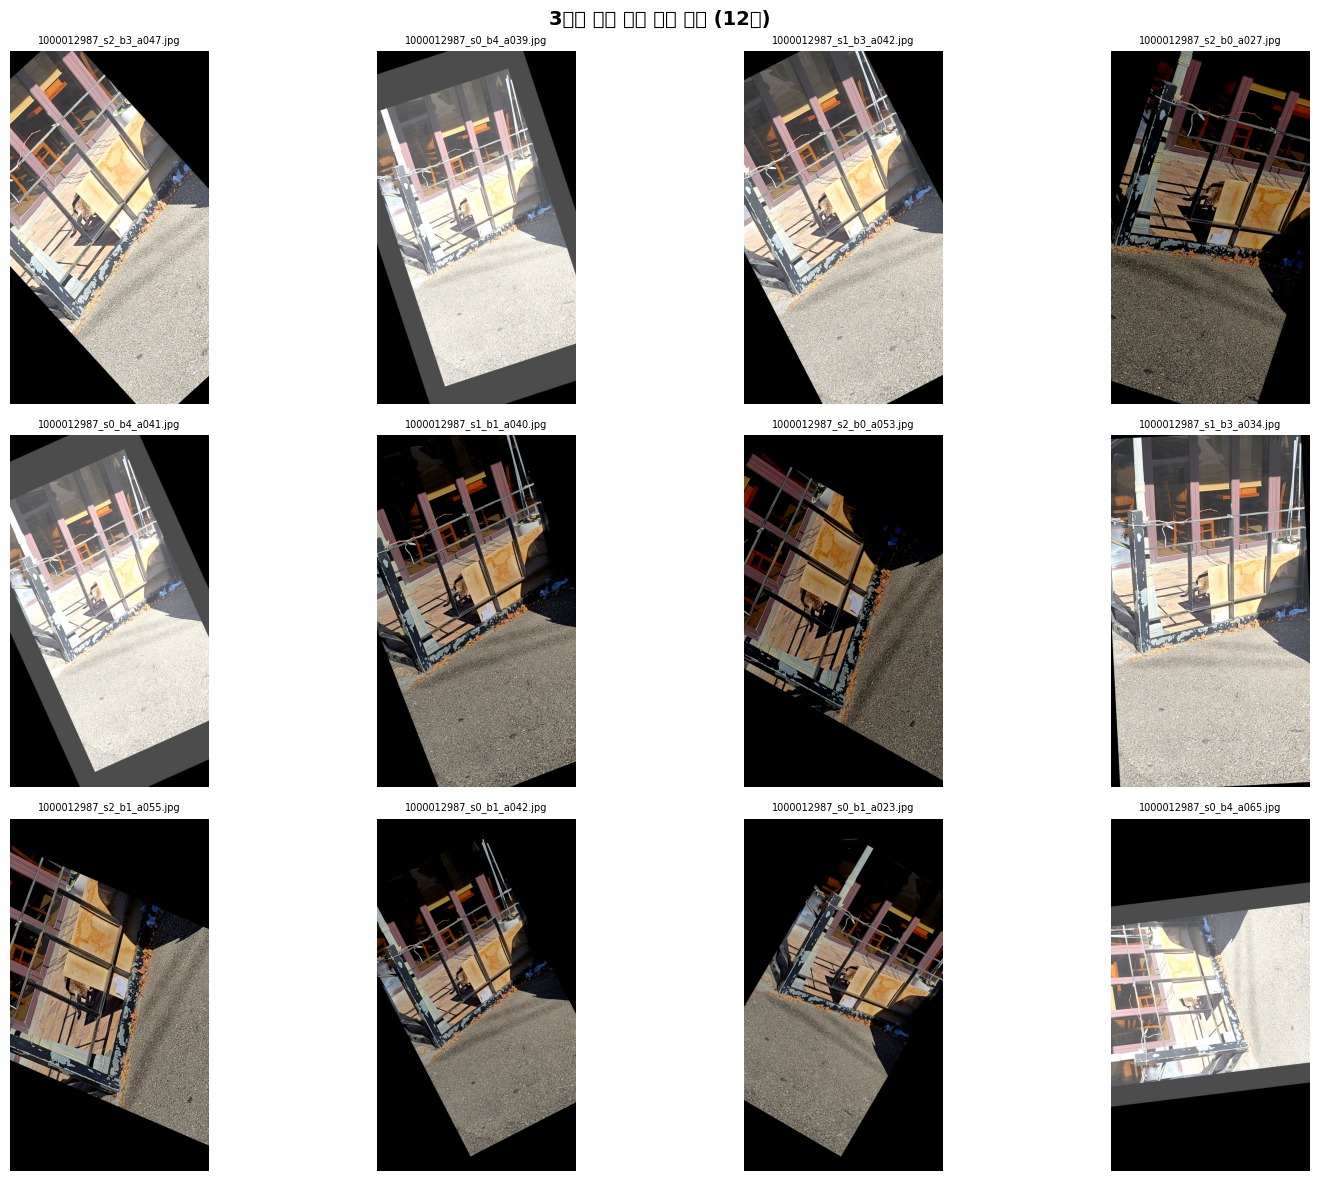

✓ 랜덤 샘플 이미지 저장: triple_results/random_samples.png


In [ ]:
# 랜덤 샘플 시각화
if len(augmented_files) > 0:
    import random
    sample_files = random.sample(augmented_files, min(12, len(augmented_files)))

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(img_path.name, fontsize=7)
        axes[idx].axis('off')

    plt.suptitle('3가지 복합 증강 랜덤 샘플 (12개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('triple_results/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 랜덤 샘플 이미지 저장: triple_results/random_samples.png")

## 10. 결과 다운로드

In [ ]:
# 증강된 이미지를 ZIP 파일로 압축
zip_filename = 'triple_augmented_images.zip'

print("ZIP 파일 생성 중...")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(augmented_files, desc="압축 진행"):
        zipf.write(file, file.name)

print(f"\n✓ ZIP 파일 생성 완료: {zip_filename}")
print(f"파일 크기: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# 다운로드
files.download(zip_filename)
print("\n다운로드가 시작되었습니다!")

ZIP 파일 생성 중...


압축 진행: 100%|██████████| 1005/1005 [01:49<00:00,  9.14it/s]


✓ ZIP 파일 생성 완료: triple_augmented_images.zip
파일 크기: 1851.53 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


다운로드가 시작되었습니다!
